# Convolutional Q8 Classification -- 5/16/2017

https://arxiv.org/pdf/1702.03865.pdf

Testing:
- multiscale convnets followed by bidirectional recurrent layer

Results:
- sadf

## Imports

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model, load_model
from keras import layers
from keras import optimizers
from keras import regularizers


import cullpdb_loader

## Constants and Hyperparameters
Declare constants about data such as the length of a protein and the number of possible residues and classes.
<br><br>
Declare hyperparameters about model such as learning rate, number of epochs of training (how many iterations through the entire data set to train for), etc.

In [16]:
NUM_RESIDUES = 700           # per protein
RESIDUE_SIZE = 22   
NUM_CLASSES = 9              # 8 + 'NoSeq'
PSSM_SIZE = 22
NUM_FEATURES = RESIDUE_SIZE  # size of one hot vector per residue

PSSM = True
if PSSM:
    NUM_FEATURES += PSSM_SIZE

INPUT_SHAPE = (NUM_RESIDUES, NUM_FEATURES)
OUTPUT_SIZE = NUM_CLASSES

LEARNING_RATE = 0.001
# regularization factor
L2 = 0.025
EPOCHS = 10
MINIBATCH = 200
LOSS='categorical_crossentropy'
OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE)

SHOW_ACCURACY = True  # set to False for quicker train ops

SAVE_FILE = "models/conv-filtered-5-16.h5py"

DATA = "data/cullpdb+profile_6133.npy.gz"
DATA_FILTERED = "data/cullpdb+profile_6133_filtered.npy.gz"
DATA_TEST = "data/cb513+profile_split1.npy.gz"

## Load Data
<b>Data:</b><br> _x represents input proteins, _y represents target structure classifications (each as one-hot vectors) <br><br>
<b>Data Shape:</b><br> First dimension represents number of proteins, second number of residues per protein, and third size of residue or structure vector.<br> For example, train_x without pssm is shape (5600, 700, 22): it is an <b>m \* n \* p</b> matrix where there are <b>m</b> proteins (each row), <b>n</b> residues per protein (each column), and <b>p</b> sized vectors to represent a single residue or a single structure (each "slice").

In [7]:
train = cullpdb_loader.load_residues(DATA_FILTERED, split=False, two_d=True, pssm=PSSM)  # load from my helper file

test = cullpdb_loader.load_cb513(DATA_TEST, two_d=True, pssm=PSSM)

# train, validation, and test were loaded as tuples of (input, output);
train_x, train_y = train
test_x, test_y = test

#train_x, train_y = train_x[:10], train_y[:10]

Loading protein residues and labels...
Loading file from C:\SANJAY\CS\Projects\sdscbio\data\cullpdb+profile_6133_filtered.npy.gz...
File Loaded.
Loaded protein residues and labels.
Reshaping...
Reshaped
Loading file from C:\SANJAY\CS\Projects\sdscbio\data\cb513+profile_split1.npy.gz...
File Loaded.


In [8]:
# print a protein to see example representation (with character labels instead of one-hot vectors)
cullpdb_loader.print_residues(train_x[0], labels=train_y[0], two_d=True)

# print to verify data was loaded in correct shapes:
print("train_x:", train_x.shape)
print("train_y", train_y.shape)
print("test_x:", test_x.shape)
print("test_y:", test_y.shape)

Residues:
FDYQTVYFANQYGLRTIELGESEFVDNTLDNQHKXVIKAAWGGGYTNRNNVVINFKVDESLCDNLYFKDTDQPLVPXPASYYTLASDRIAIPKGQIXAGVEVQLTDDFFADEKSISENYVIPLLXTNVQGADSILQGKPVVENPVLTNAGDWSILPQNFVLYAVKYVNPWHGEYLRRGIDHATVAGTSKDIIRHEQFVENDEVVNISTKSXKDNLLTLKTKDESGKDISYTVRLSFAEDGSCTVHSGSQNVVVSGSGKFVSKGEKNSLGGKDRNAIYLDYTVNLTDNNIQLATKDTLVLRTRNVYGGKSLEVVRK-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Labels:
LLLLEEELSLSEEEEEEELSLLSSSLLHHHHTTEEEEEEEEESSSSLLSLEEEEEEELGGGGTTLEETTTLLBLEELLGGGEEESLSEEEELTTLSEEEEEEEELHHHHHSGGGGSSLEEEEEEEEEEESSSEELLLEESSSSLLTTLGGGEEELLLSEEEEEEEEELTTLEEEEEEEEEEEEETTEEEEEEELLSSGGGSEEEEEEESSSSEEEEEEEEELTTSLEEEEEEEEEELTTSEEEEEELSTTLEEEEEEEEEEEEETTLGGGSLEEEEEEEEE

### Custom Accuracy Metric

The default Keras accuracy metric does not compare observations and targets over multiple dimensions. A custom method to find  accuracy must be defined.
<br><br>
Here, a <b>mask</b> is created -- a matrix with ones where the target labels have labels that are not 'NoSeq', and zeros where the target labels are 'NoSeq'. We can then do a comparison between observed and target labels, and by multiplying the resulting boolean matrix by this mask, we ignore any right/wrong labels in the trailing 'NoSeq' region (that exists only to pad the protein to the correct length).
<br><br>
This gives an accuracy metric depending only on the non-'NoSeq' labels.

In [9]:
# Second custom accuracy: ignore trailing noseq's
def custom_acc(true, obs):
    print("Using custom accuracy")
    if not SHOW_ACCURACY:
        return K.constant(float('NaN'))
    
    # -1 = placeholder for whatever's left
    obs = K.reshape(obs, [-1, 700, 9])
    true = K.reshape(true, [-1, 700, 9])
    
    # convert one-hot vectors for residues to scalars
    true_vals = K.argmax(true, axis=2)
    obs_vals = K.argmax(obs, axis=2)
    
    # mask is 2D matrix with 1s in indices that are residues
    # and 0s in indices that are 'NoSeq'
    # subtract all 8's to shift 'NoSeq' values to zero
    mask = K.sign(K.abs(true_vals - 8*K.ones_like(true_vals, dtype='int64')))
    mask = K.cast(mask, dtype=K.floatx())
    # 1D vector with each index the number of non-'NoSeq' residues 
    # in corresponding protein
    length = K.sum(mask, axis=1)
    
    # compare observed and predicted values (cast from boolean to 1s and 0s),
    # then multiply by mask to nullify any trailing 'NoSeq' equalities
    comparison = K.cast(K.equal(true_vals, obs_vals), dtype=K.floatx())
    comparison = comparison * mask
    
    # and return average
    return K.sum(comparison) / K.sum(length)

### Learning Rate Scheduler

In [10]:
def lr_sched(epoch):
    if epoch >= 20:
        return LEARNING_RATE / 10
    else:
        return LEARNING_RATE

### Block of convolutional and batch norm layers

In [11]:
def add_block(input_tensor):
    # 3 parallel convolutions
    c1 = layers.convolutional.Conv1D(32, 3, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(input_tensor)
    c2 = layers.convolutional.Conv1D(32, 7, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(input_tensor)
    c3 = layers.convolutional.Conv1D(32, 9, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(input_tensor)
    
    # depth stack of 3 convolutions with batch norm
    merge1 = layers.concatenate([c1, c2, c3])
    merge1 = layers.normalization.BatchNormalization()(merge1)
    
    # final singe convolution with batch norm
    c4 = layers.convolutional.Conv1D(16, 9, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(merge1)
    c4 = layers.normalization.BatchNormalization()(c4)
    
    # 1-window conv on inputs
    c_skip = layers.convolutional.Conv1D(1, 1, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(input_tensor)
    c_skip = layers.normalization.BatchNormalization()(c_skip)
    
    # depth concat of last conv, middle conv, and skip connection
    merge2 = layers.concatenate([c4, merge1, c_skip])
    
    return merge2    

## Model Architecture
Using only one final fully connected layer; including convolutional layer before final feedforward layer to significantly reduce feature dimensionality.
![](architecture.png)

In [12]:
input_tensor = layers.Input(shape=INPUT_SHAPE)

block1 = add_block(input_tensor)
#block1 = input_tensor

block2 = add_block(block1)

conv = layers.convolutional.Conv1D(100, 5, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(block2)

fgru = layers.recurrent.GRU(9, return_sequences=True)(conv)
bgru = layers.recurrent.GRU(9, return_sequences=True)(conv)
mergegru = layers.concatenate([fgru, bgru])

output = layers.convolutional.Conv1D(OUTPUT_SIZE, 1, 
        activation='softmax', padding='same', name="OutputLayer",
        kernel_regularizer=regularizers.l2(L2))(mergegru)
output = layers.Flatten()(output)

model = Model(inputs=input_tensor, output=output)

C:\Anaconda3\envs\sdscbio-gpu\lib\site-packages\ipykernel\__main__.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fl..., inputs=Tensor("in...)`


### Compile the model given a loss function, optimizer, and learning rate (specified above)

In [13]:
# optimizer= takes either string or optimizer object
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[custom_acc])

Using custom accuracy


In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 700, 44)       0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 700, 32)       4256                                         
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 700, 32)       9888                                         
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 700, 32)       12704                                        
___________________________________________________________________________________________

___
### Train the model on training data against target training labels, show accuracy on validation data each epoch
Here, the <b>val_loss</b> and <b>val_acc</b> are the loss and accuracy on the test data.

In [23]:
# Reshape the labels into a 2D matrix to make accuracy checks easier later on
train_y = train_y.reshape(len(train_y), NUM_CLASSES*NUM_RESIDUES)
test_y = test_y.reshape(len(test_y), NUM_CLASSES*NUM_RESIDUES)

# Training
# verbose: 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
hist = model.fit(train_x, train_y, epochs=EPOCHS, shuffle=True, verbose=2,
                 batch_size=MINIBATCH, validation_data=(test_x, test_y),
                callbacks=[keras.callbacks.LearningRateScheduler(lr_sched)])
print("Done training")

Train on 5534 samples, validate on 514 samples
Epoch 1/10
75s - loss: 4781.2995 - custom_acc: 0.7058 - val_loss: 4769.7478 - val_custom_acc: 0.6379
Epoch 2/10
75s - loss: 4774.2254 - custom_acc: 0.7153 - val_loss: 4795.8999 - val_custom_acc: 0.5929
Epoch 3/10
75s - loss: 4771.4456 - custom_acc: 0.7170 - val_loss: 4759.0003 - val_custom_acc: 0.6485
Epoch 4/10
75s - loss: 4768.8775 - custom_acc: 0.7185 - val_loss: 4759.2797 - val_custom_acc: 0.6483
Epoch 5/10
75s - loss: 4765.7072 - custom_acc: 0.7215 - val_loss: 4758.5571 - val_custom_acc: 0.6539
Epoch 6/10
75s - loss: 4763.4071 - custom_acc: 0.7244 - val_loss: 4763.0462 - val_custom_acc: 0.6361
Epoch 7/10
75s - loss: 4762.2770 - custom_acc: 0.7245 - val_loss: 4756.8247 - val_custom_acc: 0.6511
Epoch 8/10
75s - loss: 4759.8824 - custom_acc: 0.7272 - val_loss: 4760.1726 - val_custom_acc: 0.6415
Epoch 9/10
80s - loss: 4758.7062 - custom_acc: 0.7284 - val_loss: 4752.0325 - val_custom_acc: 0.6622
Epoch 10/10
83s - loss: 4756.2173 - custom_a

In [ ]:
# Reshape labels back to original shape
train_y = train_y.reshape(-1, NUM_RESIDUES, NUM_CLASSES)
test_y = test_y.reshape(-1, NUM_RESIDUES, NUM_CLASSES)

In [ ]:
model.save(SAVE_FILE)
print("model saved.")

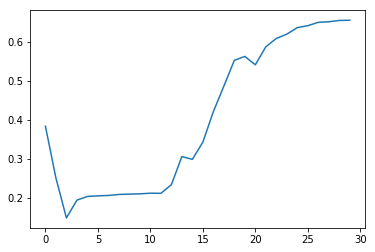

In [22]:
vali_acc = list(hist.history.values())[3]
plt.plot(range(30), vali_acc)

## Test on cb513

In [ ]:
from keras.models import load_model
model = load_model(SAVE_FILE)

In [ ]:
test_acc = model.evaluate(test_x, test_y)
print(test_acc)

In [ ]:
i = 3
prediction = model.predict(test_x[i:i+1])
prediction = prediction.reshape(700, 9)
print("Shape:", prediction.shape)

In [ ]:
print("Expected:\n")
_ = cullpdb_loader.print_residues(test_x[i], labels=test_y[i], two_d=True)
print("\nPredicted:\n")
_ = cullpdb_loader.print_residues(test_x[i], labels=prediction, two_d=True)